In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
import time

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression


from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#data source: https://www.kaggle.com/jsphyg/weather-dataset-rattle-package#weatherAUS.csv
#https://onepager.togaware.com/DataO.pdf
# grab the data
PATH = 'unit3_data/weatherAUS_rain.csv'
data = pd.read_csv(PATH)

data = shuffle(data)

## Data Exploration

In [4]:
data.head()

Date      Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
113780  19/11/2014    PearceRAAF     14.0     26.3       0.0          NaN   
10192   21/07/2012  CoffsHarbour     13.9     20.2       0.0          3.0   
118383  08/05/2010         Perth      7.5     26.2       0.0          4.6   
57505   12/02/2011       Bendigo     13.9     20.5       6.2          2.8   
138969  01/02/2017        Darwin     24.9     32.8      10.8          6.6   

        Sunshine WindGustDir  WindGustSpeed WindDir9am      ...       \
113780      13.1         WSW           43.0        SSW      ...        
10192        NaN         SSW           61.0         SW      ...        
118383       9.8          SW           20.0        NaN      ...        
57505        NaN         SSE           44.0        SSE      ...        
138969       6.1         NNE           35.0        ENE      ...        

       Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  \
113780        45.0       1015.4       1014.4       3.0       3.0     21.2   
10192         56.0       1023.6       1023.4       7.0       7.0     16.5   
118383        34.0       1018.0       1015.3       2.0       5.0     17.1   
57505         51.0       1017.7       1017.2       4.0       7.0     14.7   
138969        67.0       1007.3       1003.8       7.0       7.0     26.8   

        Temp3pm  RainToday  RISK_MM  RainTomorrow  
113780     22.8         No      0.0            No  
10192      18.5         No      0.0            No  
118383     24.7         No      0.0            No  
57505      19.6        Yes      0.0            No  
138969     31.5        Yes      9.0           Yes  

[5 rows x 24 columns]

### Display variable names for familarization and reference

In [5]:
variables = data.columns
variables

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RISK_MM', 'RainTomorrow'],
      dtype='object')

### Dealing with missing values - `nan`
**Here I'm using `missingno`(installed with `pip install missingno`) to visualize the missing observation as below**

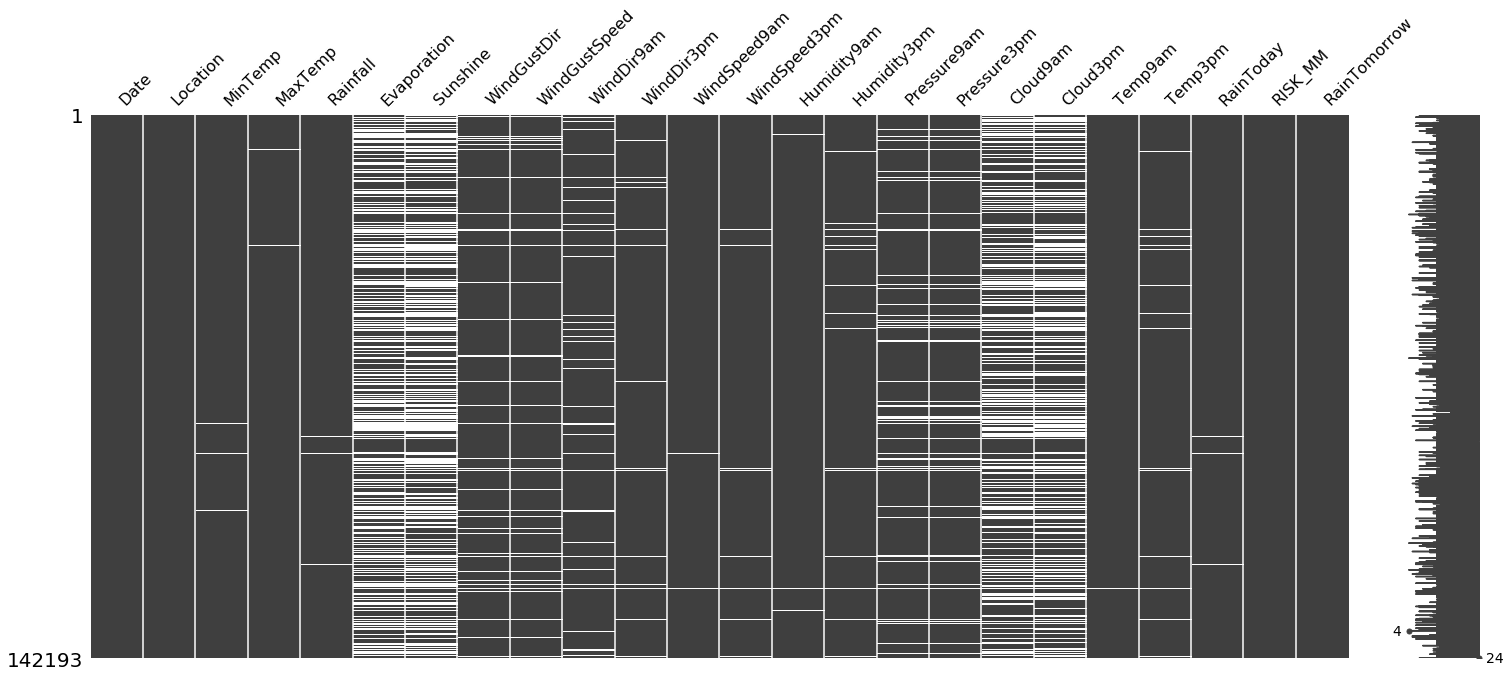

In [6]:
#source: https://towardsdatascience.com/working-with-missing-data-in-machine-learning-9c0a430df4ce

#import missingno package
import missingno as msno

#visualize missing observations in each variable
msno.matrix(data)

In [7]:
#let's see what the numbers look like accross columns in percentage
data.isnull().sum()*100/len(data)

Date              0.000000
Location          0.000000
MinTemp           0.447983
MaxTemp           0.226453
Rainfall          0.988797
Evaporation      42.789026
Sunshine         47.692924
WindGustDir       6.561504
WindGustSpeed     6.519308
WindDir9am        7.041838
WindDir3pm        2.656952
WindSpeed9am      0.948007
WindSpeed3pm      1.849599
Humidity9am       1.247600
Humidity3pm       2.538803
Pressure9am       9.855619
Pressure3pm       9.832411
Cloud9am         37.735332
Cloud3pm         40.152469
Temp9am           0.635756
Temp3pm           1.917113
RainToday         0.988797
RISK_MM           0.000000
RainTomorrow      0.000000
dtype: float64

**We have a huge amount of missing data here, ranging from 0 up to 48% accross both the numerical and categorical variables. This sure calls for a creative fix. I will split the data into categorical and numerical, treat each group accordingly and concatenate them into one again.**

#### Missing Data - Numerical

In [8]:
#get the numerical numerical split
data_numeric = data._get_numeric_data().copy()
data_numeric.head()

MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
113780     14.0     26.3       0.0          NaN      13.1           43.0   
10192      13.9     20.2       0.0          3.0       NaN           61.0   
118383      7.5     26.2       0.0          4.6       9.8           20.0   
57505      13.9     20.5       6.2          2.8       NaN           44.0   
138969     24.9     32.8      10.8          6.6       6.1           35.0   

        WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  \
113780          17.0          24.0         55.0         45.0       1015.4   
10192           39.0          41.0         62.0         56.0       1023.6   
118383           0.0           9.0         48.0         34.0       1018.0   
57505           28.0          20.0         68.0         51.0       1017.7   
138969           6.0          11.0         88.0         67.0       1007.3   

        Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RISK_MM  
113780       1014.4       3.0       3.0     21.2     22.8      0.0  
10192        1023.4       7.0       7.0     16.5     18.5      0.0  
118383       1015.3       2.0       5.0     17.1     24.7      0.0  
57505        1017.2       4.0       7.0     14.7     19.6      0.0  
138969       1003.8       7.0       7.0     26.8     31.5      9.0

**Let's check if there are other outliers(aside from the nan them selves) in any of the variables with huge number of missing values as this will inform us to use either the mean or median of the variable to fill it's nan rows .**

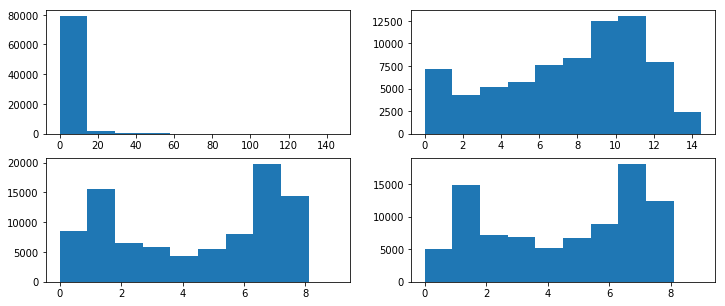

In [9]:
#let's do a subplot of the four variable with the most number of missing values
plt.figure(figsize=(12,5))

plt.subplot(2, 2, 1)
plt.hist(data_numeric.Evaporation)

plt.subplot(2, 2, 2)
plt.hist(data_numeric.Sunshine)

plt.subplot(2, 2, 3)
plt.hist(data_numeric.Cloud9am)

plt.subplot(2, 2, 4)
plt.hist(data_numeric.Cloud3pm)

plt.show()

**We have outliers in `Evaporation`, I will use the `median` to fill the `nan` for this variable while using the `mean` for the other three.**

In [10]:
#import imputer
##from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer
#create mean and median imputers
imputer_median = SimpleImputer(missing_values=np.nan, strategy='median')
imputer_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

#apply imputers
data_numeric['Evaporation'] = imputer_median.fit_transform(data_numeric[['Evaporation']]).copy()
data_numeric[['Sunshine', 'Cloud9am', 'Cloud3pm']] = imputer_mean.fit_transform(data_numeric[['Sunshine', 'Cloud9am', 'Cloud3pm']]).copy()

#use the mean imputer for all other missing values in the numerical variables, 
#RISK_MM will not change at it does not have any missing values
data_numeric[data_numeric.columns] = imputer_mean.fit_transform(data_numeric[data_numeric.columns]).copy()

#### Missing Data - Categorical

In [11]:
#get the categorical split
data_cat = data.loc[:, ~data.columns.isin(data_numeric.columns)].copy()
data_cat.head()

Date      Location WindGustDir WindDir9am WindDir3pm RainToday  \
113780  19/11/2014    PearceRAAF         WSW        SSW         SW        No   
10192   21/07/2012  CoffsHarbour         SSW         SW        SSW        No   
118383  08/05/2010         Perth          SW        NaN        WSW        No   
57505   12/02/2011       Bendigo         SSE        SSE          S       Yes   
138969  01/02/2017        Darwin         NNE        ENE          N       Yes   

       RainTomorrow  
113780           No  
10192            No  
118383           No  
57505            No  
138969          Yes

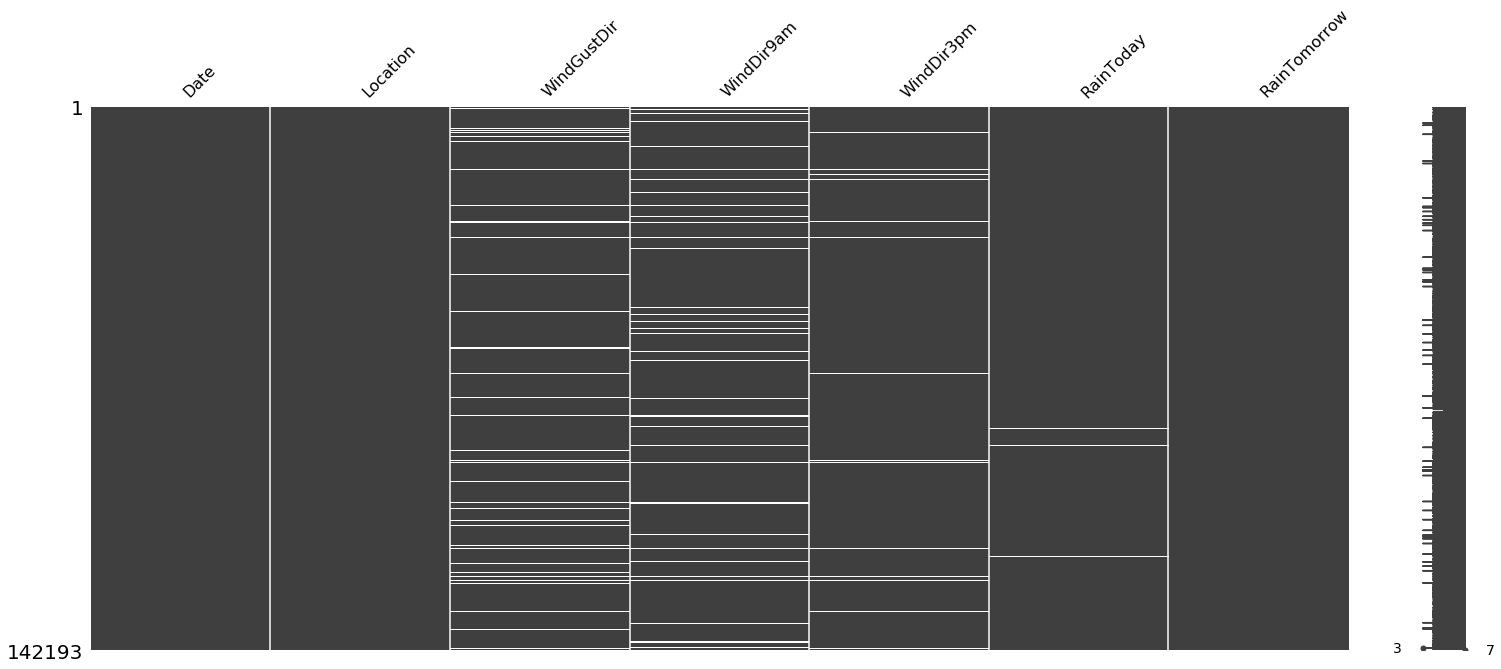

In [12]:
msno.matrix(data_cat)
    

**The three categorical variables of interest are `WindGustDir, WindDir9am and WindDir3pm`. They all have the same 12 unique strings which are almost equally distributed in their columns. There's no clear cut dominant observation. Here I will fill the `nan` by randomly sampling all the 12 unique observation for each variable. `RainToday` also has around `1406` missing values, which is pretty insignificant. I will drop the rows after concatenating the data back into a whole.** 

In [13]:
#create a set of keys to fill nan with
def fill_nan_with_random(df2, column):
    keys = df2[column].dropna().values
    #Fill `df2`'s column with name `column` with random data based on non-NaN data from `column`
    df = df2.copy()
    #df[column] = df[column].apply(lambda x: np.random.choice(df[column].dropna().values) if np.isnan(x) else x)
    df[column] = df[column].apply(lambda x: np.random.choice(keys) if x not in keys else x).copy()
    
    #returns a new feature to replace the old one
    return df[column]

In [14]:
data_cat['WindGustDir'] = fill_nan_with_random(data_cat, 'WindGustDir').copy()
data_cat['WindDir9am'] = fill_nan_with_random(data_cat, 'WindDir9am').copy()
data_cat['WindDir3pm'] = fill_nan_with_random(data_cat, 'WindDir3pm').copy()

In [15]:
data_cat.head()

Date      Location WindGustDir WindDir9am WindDir3pm RainToday  \
113780  19/11/2014    PearceRAAF         WSW        SSW         SW        No   
10192   21/07/2012  CoffsHarbour         SSW         SW        SSW        No   
118383  08/05/2010         Perth          SW        WSW        WSW        No   
57505   12/02/2011       Bendigo         SSE        SSE          S       Yes   
138969  01/02/2017        Darwin         NNE        ENE          N       Yes   

       RainTomorrow  
113780           No  
10192            No  
118383           No  
57505            No  
138969          Yes

**Now I will concatenate the `data_numeric` and `data_cat` back into `data` and remove the final `nan` in `RainToday`**

In [16]:
#concatenate back to data
data = pd.concat([data_numeric, data_cat ], axis=1)
data.head()

MinTemp  MaxTemp  Rainfall  Evaporation   Sunshine  WindGustSpeed  \
113780     14.0     26.3       0.0          4.8  13.100000           43.0   
10192      13.9     20.2       0.0          3.0   7.624853           61.0   
118383      7.5     26.2       0.0          4.6   9.800000           20.0   
57505      13.9     20.5       6.2          2.8   7.624853           44.0   
138969     24.9     32.8      10.8          6.6   6.100000           35.0   

        WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm     ...       \
113780          17.0          24.0         55.0         45.0     ...        
10192           39.0          41.0         62.0         56.0     ...        
118383           0.0           9.0         48.0         34.0     ...        
57505           28.0          20.0         68.0         51.0     ...        
138969           6.0          11.0         88.0         67.0     ...        

        Temp9am  Temp3pm  RISK_MM        Date      Location  WindGustDir  \
113780     21.2     22.8      0.0  19/11/2014    PearceRAAF          WSW   
10192      16.5     18.5      0.0  21/07/2012  CoffsHarbour          SSW   
118383     17.1     24.7      0.0  08/05/2010         Perth           SW   
57505      14.7     19.6      0.0  12/02/2011       Bendigo          SSE   
138969     26.8     31.5      9.0  01/02/2017        Darwin          NNE   

        WindDir9am WindDir3pm RainToday RainTomorrow  
113780         SSW         SW        No           No  
10192           SW        SSW        No           No  
118383         WSW        WSW        No           No  
57505          SSE          S       Yes           No  
138969         ENE          N       Yes          Yes  

[5 rows x 24 columns]

**Now I will finally drop the `nan` in RainToday and re-check the data again to be sure that all `nan` are gone**

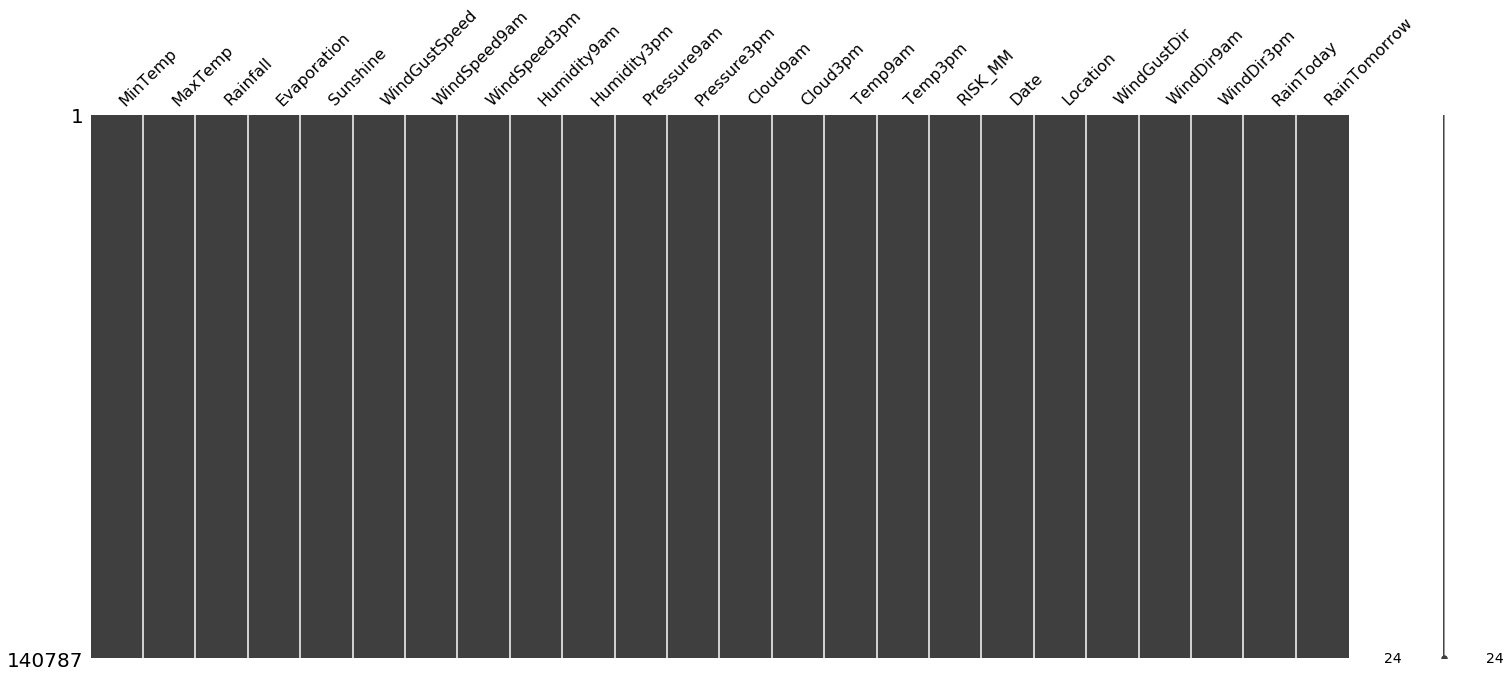

In [17]:
#dropna
data = data.dropna().copy()

#just to be sure that all na are gone
msno.matrix(data)

### Next, let's see what the distribution of the numerical variables in our data look like.

In [18]:
data.describe()

MinTemp        MaxTemp       Rainfall    Evaporation  \
count  140787.000000  140787.000000  140787.000000  140787.000000   
mean       12.184829      23.235102       2.349974       5.187367   
std         6.393226       7.106739       8.465173       3.196637   
min        -8.500000      -4.800000       0.000000       0.000000   
25%         7.600000      17.900000       0.000000       4.000000   
50%        12.000000      22.700000       0.000000       4.800000   
75%        16.800000      28.200000       0.800000       5.400000   
max        33.900000      48.100000     371.000000     145.000000   

            Sunshine  WindGustSpeed   WindSpeed9am   WindSpeed3pm  \
count  140787.000000  140787.000000  140787.000000  140787.000000   
mean        7.627841      39.971411      13.990582      18.631256   
std         2.741391      13.131795       8.852853       8.718653   
min         0.000000       6.000000       0.000000       0.000000   
25%         7.624853      31.000000       7.000000      13.000000   
50%         7.624853      39.000000      13.000000      18.637576   
75%         8.700000      46.000000      19.000000      24.000000   
max        14.500000     135.000000     130.000000      87.000000   

         Humidity9am    Humidity3pm    Pressure9am    Pressure3pm  \
count  140787.000000  140787.000000  140787.000000  140787.000000   
mean       68.827016      51.450117    1017.654497    1015.257986   
std        18.960664      20.546969       6.749189       6.682526   
min         0.000000       0.000000     980.500000     977.100000   
25%        57.000000      37.000000    1013.500000    1011.000000   
50%        70.000000      51.482606    1017.653758    1015.258204   
75%        83.000000      65.000000    1021.800000    1019.400000   
max       100.000000     100.000000    1041.000000    1039.600000   

            Cloud9am       Cloud3pm        Temp9am        Temp3pm  \
count  140787.000000  140787.000000  140787.000000  140787.000000   
mean        4.433414       4.500811      16.987068      21.693072   
std         2.284255       2.109459       6.480860       6.872826   
min         0.000000       0.000000      -7.200000      -5.400000   
25%         3.000000       4.000000      12.300000      16.700000   
50%         4.437189       4.503167      16.800000      21.300000   
75%         6.000000       6.000000      21.500000      26.300000   
max         9.000000       9.000000      40.200000      46.700000   

             RISK_MM  
count  140787.000000  
mean        2.313202  
std         8.334842  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.600000  
max       371.000000

In [19]:
data.describe().columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RISK_MM'],
      dtype='object')

In [20]:
#list non numeriacal variables
non_numeric_var = [item for item in variables if item not in data.describe().columns]
non_numeric_var

['Date',
 'Location',
 'WindGustDir',
 'WindDir9am',
 'WindDir3pm',
 'RainToday',
 'RainTomorrow']

**From the output above, we can see that only 7 out of the 24 variables in our dataset are non-numerical. I explore each of the non-numerical variable further and see how they can be applied in a model.** 

### Variable `Date`

In [21]:
#check if each date observation is unique
len(data.Date.unique())

3436

**There are just `3436` unique dates in our data, this shows that `Date` is not unique to observations and could add value in a model. In order to apply `Date` in a model, I will split this variable into `Day`, `Month` and `Year`.**

In [22]:
#split date into day, month, and year
data['day'] = pd.DatetimeIndex(data['Date'], dayfirst=True).day
data['month'] = pd.DatetimeIndex(data['Date'], dayfirst=True).month 
data['year'] = pd.DatetimeIndex(data['Date'], dayfirst=True).year

#drop Date from dataset
data.drop(['Date'], axis=1, inplace=True)
data.head()

MinTemp  MaxTemp  Rainfall  Evaporation   Sunshine  WindGustSpeed  \
113780     14.0     26.3       0.0          4.8  13.100000           43.0   
10192      13.9     20.2       0.0          3.0   7.624853           61.0   
118383      7.5     26.2       0.0          4.6   9.800000           20.0   
57505      13.9     20.5       6.2          2.8   7.624853           44.0   
138969     24.9     32.8      10.8          6.6   6.100000           35.0   

        WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  ...   RISK_MM  \
113780          17.0          24.0         55.0         45.0  ...       0.0   
10192           39.0          41.0         62.0         56.0  ...       0.0   
118383           0.0           9.0         48.0         34.0  ...       0.0   
57505           28.0          20.0         68.0         51.0  ...       0.0   
138969           6.0          11.0         88.0         67.0  ...       9.0   

            Location  WindGustDir  WindDir9am  WindDir3pm  RainToday  \
113780    PearceRAAF          WSW         SSW          SW         No   
10192   CoffsHarbour          SSW          SW         SSW         No   
118383         Perth           SW         WSW         WSW         No   
57505        Bendigo          SSE         SSE           S        Yes   
138969        Darwin          NNE         ENE           N        Yes   

        RainTomorrow day month  year  
113780            No  19    11  2014  
10192             No  21     7  2012  
118383            No   8     5  2010  
57505             No  12     2  2011  
138969           Yes   1     2  2017  

[5 rows x 26 columns]

### Variable `Location`

In [23]:
data.Location.value_counts(), len(data.Location.value_counts())

(Canberra            3402
 Sydney              3331
 Perth               3193
 Darwin              3192
 Hobart              3183
 Brisbane            3132
 Bendigo             3030
 Townsville          3027
 AliceSprings        3025
 MountGambier        3022
 Adelaide            3020
 Launceston          3020
 Ballarat            3017
 PerthAirport        3009
 MelbourneAirport    3009
 Mildura             3005
 SydneyAirport       3001
 Albany              2996
 Nuriootpa           2996
 Sale                2992
 Albury              2991
 Watsonia            2990
 Woomera             2984
 Portland            2984
 Cobar               2980
 Cairns              2964
 Tuggeranong         2959
 WaggaWagga          2958
 NorfolkIsland       2944
 Wollongong          2943
 SalmonGums          2941
 CoffsHarbour        2940
 Dartmoor            2939
 Newcastle           2929
 Witchcliffe         2924
 GoldCoast           2924
 Penrith             2911
 Richmond            2906
 NorahHead  

**As seen above, `Location` has `49` unique observations. This variable will not be a good candidate for factorizarion as it can only be ordered alphabetically which would not add any statiscal value. I will encode it with `1-hot-encoding` later on**

### Variable `WindGustDir`, `WindDir9am` and `WindDir3pm`

In [24]:
#pd.DataFrame({'WindGustDirdata': data.WindGustDir.unique(), 'WindGustDirdata': data.WindGustDir.unique() })
data.WindGustDir.value_counts(), data.WindDir9am.value_counts(), data.WindDir3pm.value_counts()

(W      10404
 SE      9867
 E       9598
 N       9563
 S       9531
 SSE     9518
 WSW     9372
 SW      9288
 SSW     9120
 NW      8516
 ENE     8499
 WNW     8493
 ESE     7768
 NE      7475
 NNW     6954
 NNE     6821
 Name: WindGustDir, dtype: int64, N      12109
 SE      9768
 E       9584
 SSE     9562
 NW      9069
 S       9062
 W       8829
 SW      8722
 NNE     8501
 NNW     8417
 ENE     8245
 ESE     8083
 NE      8020
 SSW     7930
 WNW     7620
 WSW     7266
 Name: WindDir9am, dtype: int64, SE     10862
 W      10078
 S       9735
 WSW     9472
 SW      9350
 SSE     9281
 N       8838
 WNW     8779
 NW      8618
 ESE     8526
 E       8489
 NE      8296
 SSW     8154
 ENE     7884
 NNW     7878
 NNE     6547
 Name: WindDir3pm, dtype: int64)

**These three variables have the same set of 16 uniques observations which we can either encode with `1-hot-encode` or factorize. In this case since we know that wind direction has a standard order starting from N and going clockwise to WWN, it will be logical to order these unique observations and make a numerical factor out of them with N = 0 through to WWN = 15**

In [25]:
#create the generic wind direction list in the correct order as a set of keys for maping 
keys = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']

#create the coresponding list of values from 0 to 15
values = list(range(0, 16, 1))

#create new features with the maped values
data['WindGustDir_numeric'] = data.WindGustDir.map(dict(zip(keys, values)))
data['WindDir9am_numeric'] = data.WindDir9am.map(dict(zip(keys, values)))
data['WindDir3pm_numeric'] = data.WindDir3pm.map(dict(zip(keys, values)))

#drop the old string features
data.drop(['WindGustDir', 'WindDir9am', 'WindDir3pm'], axis=1, inplace=True)

#let's see what we got
data.head()

MinTemp  MaxTemp  Rainfall  Evaporation   Sunshine  WindGustSpeed  \
113780     14.0     26.3       0.0          4.8  13.100000           43.0   
10192      13.9     20.2       0.0          3.0   7.624853           61.0   
118383      7.5     26.2       0.0          4.6   9.800000           20.0   
57505      13.9     20.5       6.2          2.8   7.624853           44.0   
138969     24.9     32.8      10.8          6.6   6.100000           35.0   

        WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  \
113780          17.0          24.0         55.0         45.0   
10192           39.0          41.0         62.0         56.0   
118383           0.0           9.0         48.0         34.0   
57505           28.0          20.0         68.0         51.0   
138969           6.0          11.0         88.0         67.0   

              ...          RISK_MM      Location  RainToday  RainTomorrow  \
113780        ...              0.0    PearceRAAF         No            No   
10192         ...              0.0  CoffsHarbour         No            No   
118383        ...              0.0         Perth         No            No   
57505         ...              0.0       Bendigo        Yes            No   
138969        ...              9.0        Darwin        Yes           Yes   

        day  month  year WindGustDir_numeric WindDir9am_numeric  \
113780   19     11  2014                  11                  9   
10192    21      7  2012                   9                 10   
118383    8      5  2010                  10                 11   
57505    12      2  2011                   7                  7   
138969    1      2  2017                   1                  3   

       WindDir3pm_numeric  
113780                 10  
10192                   9  
118383                 11  
57505                   8  
138969                  0  

[5 rows x 26 columns]

### Variable `RainToday`

In [26]:
data.RainToday.value_counts()

No     109332
Yes     31455
Name: RainToday, dtype: int64

**Rain Today is a binary variable. I will tranform it into a `binary factor`. Rather than using `np.where`, I will be using `mapping` so as to be able to retain the `nan` datapoints**

In [27]:
#implement mapping and drop the old RainToday column
data['RainToday_numeric'] = data.RainToday.map({'Yes':1, 'No':0}).copy()
data.drop(['RainToday'], axis=1, inplace=True)

### Variable `RainTomorrow` 

In [28]:
data.RainTomorrow.value_counts()

No     109586
Yes     31201
Name: RainTomorrow, dtype: int64

**RainTomorrow is a binary variable. I will tranform it into a `binary factor` using np.where. This is also the target variable for the classification model that will be built in this project.**

In [29]:
data['RainTomorrow_numeric'] = np.where(data.RainTomorrow=='Yes', 1, 0)
data.drop(['RainTomorrow'], axis=1, inplace=True)

## Further Data Exploration - Bivariate 
After exploring and creating features from the non numerical variable, we will now explore the numerical variable.

### Pairplot
First let's do a pair plot of the numerical variables.

<Figure size 1008x1008 with 0 Axes>

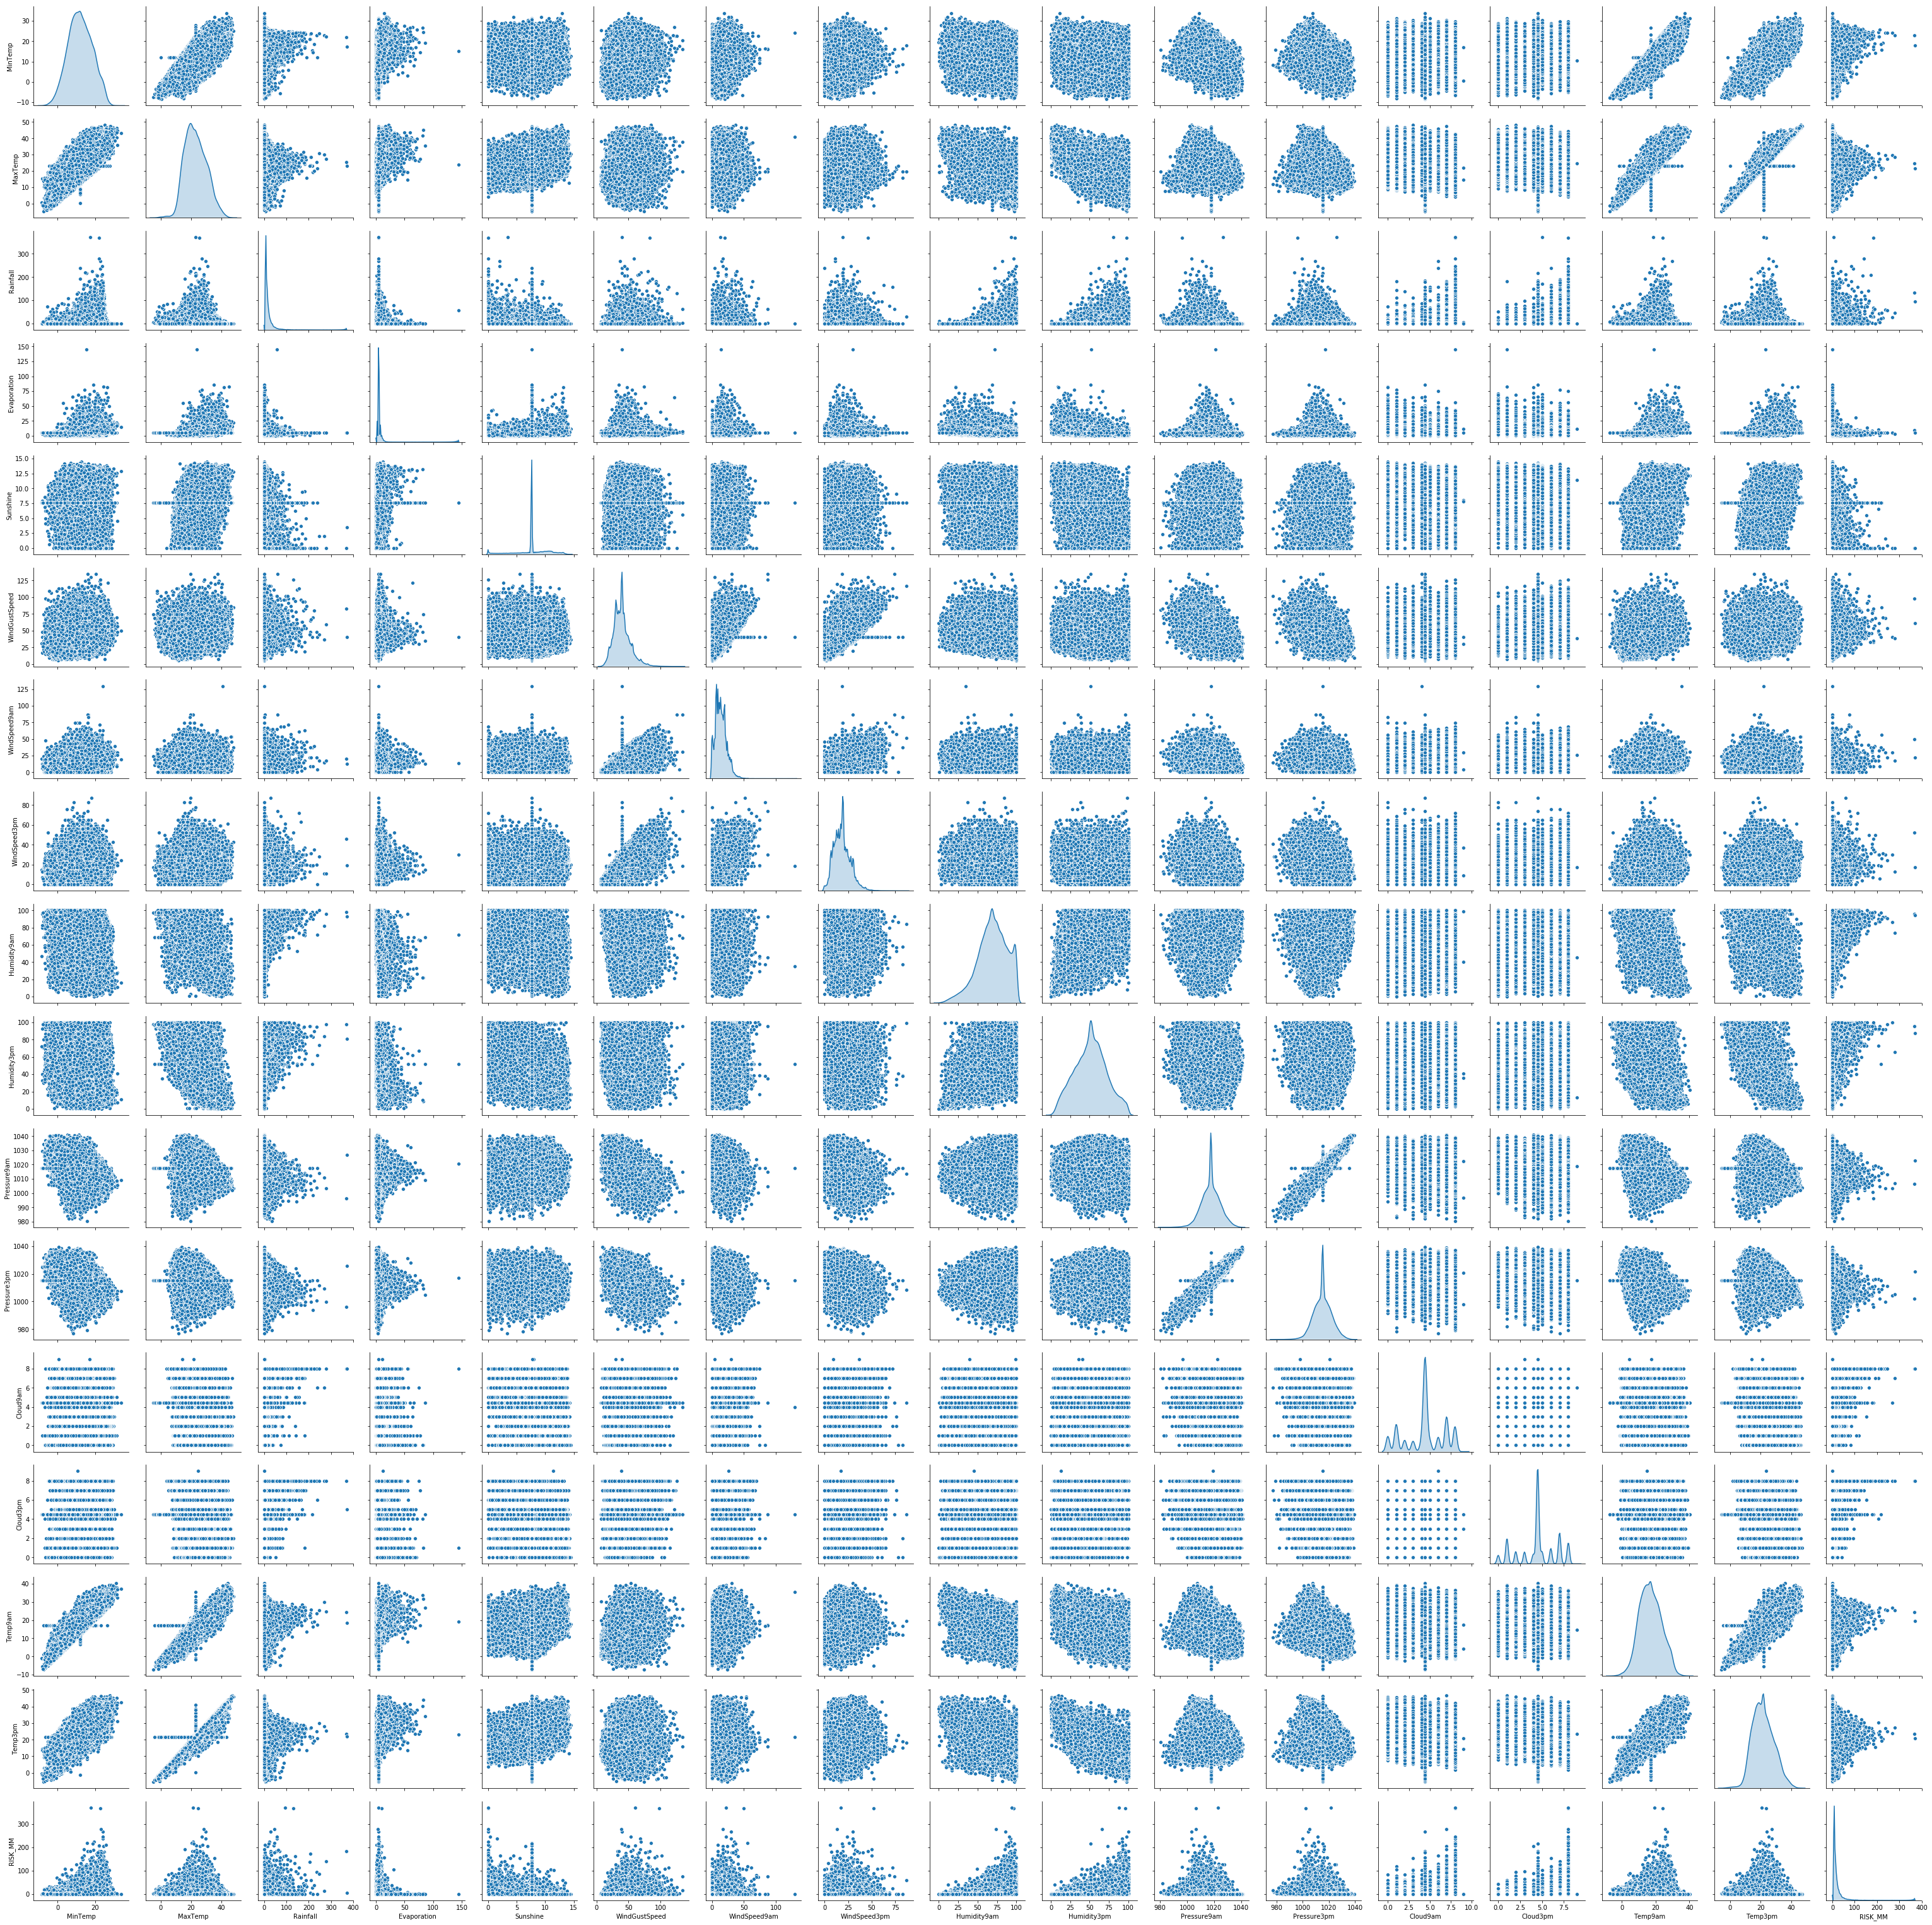

In [30]:
#copy the list of numerical column names from cell 87 above
num_list = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RISK_MM']
#create figure and plot pairplot
plt.figure(figsize=(14, 14))
sns.pairplot(data[num_list], diag_kind='kde');

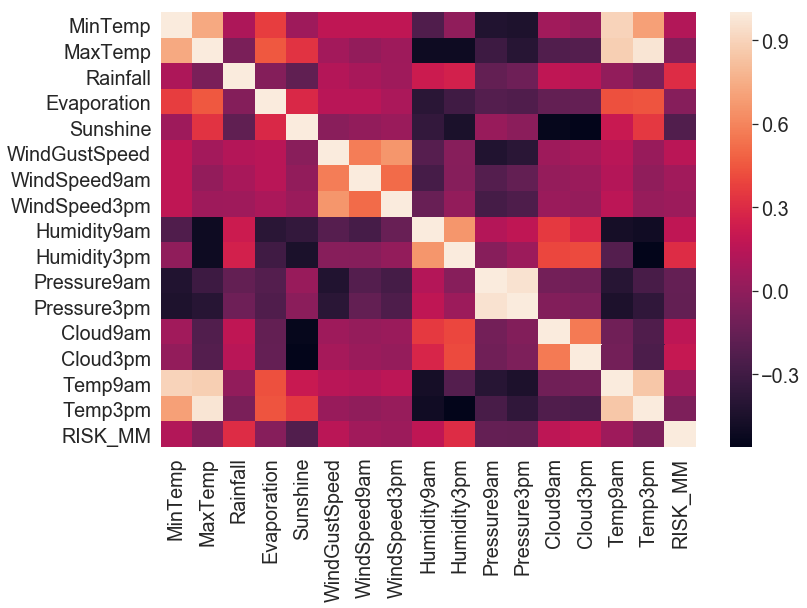

In [186]:
plt.figure(figsize=(12, 8))

data_corr = data[num_list].corr()
sns.set(font_scale=1.8)
#sns.set_color('w')
sns.heatmap(data_corr, 
            xticklabels = data_corr.columns.values,
            yticklabels = data_corr.columns.values);

**No obvious case of high correlation here. All the features will thereby be retained the way they are. But I will `encode` city with `1-hot-emcode` right away**

In [32]:
data = pd.get_dummies(data).copy()
data.head()

MinTemp  MaxTemp  Rainfall  Evaporation   Sunshine  WindGustSpeed  \
113780     14.0     26.3       0.0          4.8  13.100000           43.0   
10192      13.9     20.2       0.0          3.0   7.624853           61.0   
118383      7.5     26.2       0.0          4.6   9.800000           20.0   
57505      13.9     20.5       6.2          2.8   7.624853           44.0   
138969     24.9     32.8      10.8          6.6   6.100000           35.0   

        WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  \
113780          17.0          24.0         55.0         45.0   
10192           39.0          41.0         62.0         56.0   
118383           0.0           9.0         48.0         34.0   
57505           28.0          20.0         68.0         51.0   
138969           6.0          11.0         88.0         67.0   

              ...         Location_Townsville  Location_Tuggeranong  \
113780        ...                           0                     0   
10192         ...                           0                     0   
118383        ...                           0                     0   
57505         ...                           0                     0   
138969        ...                           0                     0   

        Location_Uluru  Location_WaggaWagga  Location_Walpole  \
113780               0                    0                 0   
10192                0                    0                 0   
118383               0                    0                 0   
57505                0                    0                 0   
138969               0                    0                 0   

        Location_Watsonia  Location_Williamtown  Location_Witchcliffe  \
113780                  0                     0                     0   
10192                   0                     0                     0   
118383                  0                     0                     0   
57505                   0                     0                     0   
138969                  0                     0                     0   

        Location_Wollongong  Location_Woomera  
113780                    0                 0  
10192                     0                 0  
118383                    0                 0  
57505                     0                 0  
138969                    0                 0  

[5 rows x 74 columns]

### Seperate Independent and Target Variables

In [33]:
#target variable for classification
Y_class = data.RainTomorrow_numeric.copy()

#target variable for regression
Y_regr = data.RISK_MM.copy()

#independent varaibles
X = data.loc[:, ~data.columns.isin(['RainTomorrow_numeric', 'RISK_MM'])].copy()
X.head()

MinTemp  MaxTemp  Rainfall  Evaporation   Sunshine  WindGustSpeed  \
113780     14.0     26.3       0.0          4.8  13.100000           43.0   
10192      13.9     20.2       0.0          3.0   7.624853           61.0   
118383      7.5     26.2       0.0          4.6   9.800000           20.0   
57505      13.9     20.5       6.2          2.8   7.624853           44.0   
138969     24.9     32.8      10.8          6.6   6.100000           35.0   

        WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  \
113780          17.0          24.0         55.0         45.0   
10192           39.0          41.0         62.0         56.0   
118383           0.0           9.0         48.0         34.0   
57505           28.0          20.0         68.0         51.0   
138969           6.0          11.0         88.0         67.0   

              ...         Location_Townsville  Location_Tuggeranong  \
113780        ...                           0                     0   
10192         ...                           0                     0   
118383        ...                           0                     0   
57505         ...                           0                     0   
138969        ...                           0                     0   

        Location_Uluru  Location_WaggaWagga  Location_Walpole  \
113780               0                    0                 0   
10192                0                    0                 0   
118383               0                    0                 0   
57505                0                    0                 0   
138969               0                    0                 0   

        Location_Watsonia  Location_Williamtown  Location_Witchcliffe  \
113780                  0                     0                     0   
10192                   0                     0                     0   
118383                  0                     0                     0   
57505                   0                     0                     0   
138969                  0                     0                     0   

        Location_Wollongong  Location_Woomera  
113780                    0                 0  
10192                     0                 0  
118383                    0                 0  
57505                     0                 0  
138969                    0                 0  

[5 rows x 72 columns]

### Split data into test and train sets using ration `9 : 1`

In [34]:
#define and offset
offset = int(X.shape[0]*0.9)

#split X
x_train, x_test = X[: offset], X[offset :]

#split Y for classification
y_train_class, y_test_class = Y_class[: offset], Y_class[offset :]

#split Y for regression
y_train_regr, y_test_regr = Y_regr[: offset], Y_regr[offset :]

# Classification Model

### Define function to run classification model

In [35]:
from sklearn.tree import DecisionTreeClassifier

#create model with default parameters
dtm_default = DecisionTreeClassifier()

In [125]:

#from sklearn.metrics import roc_auc_score

def modelfit(alg, X_train, Y_train, X_test, Y_test, printConfMatrix=True, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(X_train, Y_train)
        
    #Predict training set:
    dtrain_predictions = alg.predict(X_train)
    dtrain_predprob = alg.predict_proba(X_train)[:,1]
    
    #Predict test set:
    dtest_predictions = alg.predict(X_test)
    dtest_predprob = alg.predict_proba(X_test)[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, X_train, Y_train, cv=cv_folds, scoring='roc_auc')
        
    accuracy_train = metrics.accuracy_score(Y_train.values, dtrain_predictions)
    AUC_train = metrics.roc_auc_score(Y_train, dtrain_predprob)    
    
    accuracy_test = metrics.accuracy_score(Y_test.values, dtest_predictions)
    AUC_test = metrics.roc_auc_score(Y_test, dtest_predprob)
    
    #if confusion matrix is required, else skip below lines
    if printConfMatrix:
        print("\nConfusion Matrix - Train")
        print(pd.DataFrame(confusion_matrix(Y_train, dtrain_predictions)))
        print("\nConfusion Matrix - Test")
        print(pd.DataFrame(confusion_matrix(Y_test, dtest_predictions)))
        print()
    
    #Print model report:
    print("\nModel Report - Train")
    print("Accuracy : %.4g" % accuracy_train)  
    print("AUC Score (Train): %f" % AUC_train)   
    print()

    
    if performCV:
        CV_mean = np.mean(cv_score)
        CV_std = np.std(cv_score)
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (CV_mean,CV_std,np.min(cv_score),np.max(cv_score)))
    
    print("\nModel Report - Test")
    print("Accuracy : %.4g" % accuracy_test)
    print("AUC Score (Test): %f" % AUC_test)


    #Print Feature Importance:
    if printFeatureImportance:
        with plt.rc_context({'axes.edgecolor': 'white', 
                             'xtick.color':'white', 
                             'ytick.color':'white', 
                             'figure.facecolor':'black', 
                             'xtick.labelsize':14, 
                             'ytick.labelsize':14, 
                             'axes.facecolor':'black'}):
            feat_imp = pd.Series(alg.feature_importances_, X_train.columns).sort_values(ascending=False)
            #select top 20 features only
            feat_imp = feat_imp[:25]
            plt.figure(figsize=(10,5))
            feat_imp.plot(kind='bar')
            plt.ylabel('Feature Importance Score')
            plt.title('Feature Importances', color='white', fontsize=20)
        
#-------------------------------------------------------------------------
        
    return accuracy_train, AUC_train, CV_mean, CV_std, accuracy_test, AUC_test, dtrain_predprob, dtest_predprob

### Baseline `Decistion Tree` Model

In [126]:
from sklearn.tree import DecisionTreeClassifier

#create model with default parameters
dtm_default = DecisionTreeClassifier()


Confusion Matrix - Train
       0      1
0  98630      0
1      0  28078

Confusion Matrix - Test
      0     1
0  9430  1526
1  1431  1692


Model Report - Train
Accuracy : 1
AUC Score (Train): 1.000000

CV Score : Mean - 0.7015779 | Std - 0.00165296 | Min - 0.6995166 | Max - 0.7036776

Model Report - Test
Accuracy : 0.79
AUC Score (Test): 0.701251


(1.0,
 1.0,
 0.7015778865585407,
 0.0016529598273172757,
 0.7899708786135379,
 0.7012511665735511,
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 1., 1., 0.]))

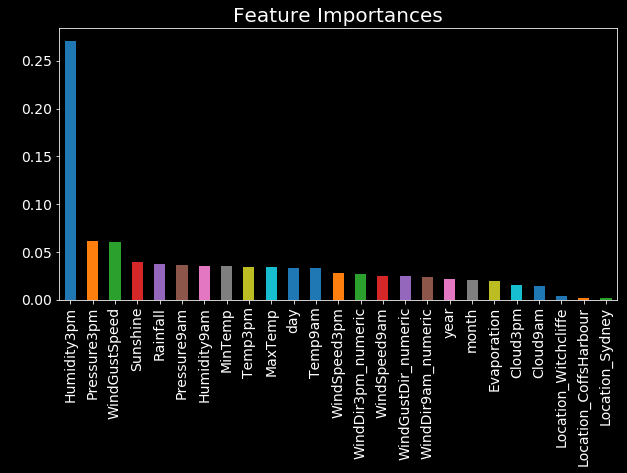

In [127]:
modelfit(dtm_default, x_train, y_train_class, x_test, y_test_class, printConfMatrix=True, performCV=True, printFeatureImportance=True, cv_folds=5)

In [39]:
#Space for comment

### Baseline `Gradient Boosting` Model


Confusion Matrix - Train
       0      1
0  93979   4651
1  13758  14320

Confusion Matrix - Test
       0     1
0  10419   537
1   1572  1551


Model Report - Train
Accuracy : 0.8547
AUC Score (Train): 0.880044

CV Score : Mean - 0.8766503 | Std - 0.002671221 | Min - 0.874597 | Max - 0.8818598

Model Report - Test
Accuracy : 0.8502
AUC Score (Test): 0.880967


(0.8547131988509012,
 0.8800435271936984,
 0.8766502558735008,
 0.0026712207139010574,
 0.8502024291497976,
 0.8809670902046166,
 array([0.02845008, 0.23984642, 0.02950481, ..., 0.11497711, 0.05922083,
        0.07752834]),
 array([0.30452034, 0.29117435, 0.58315633, ..., 0.89095652, 0.9093931 ,
        0.04223134]))

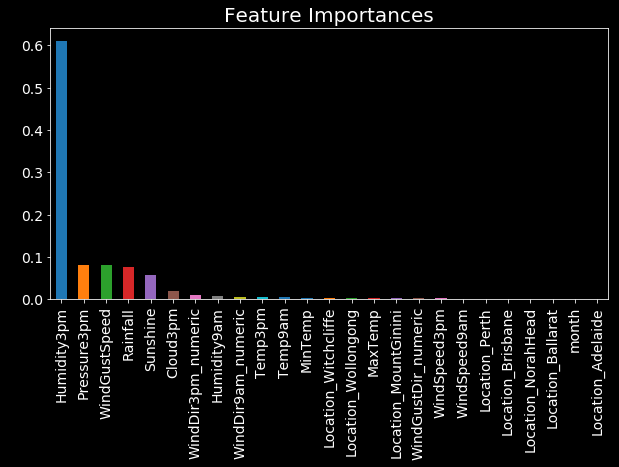

In [155]:
gbm_baselins = GradientBoostingClassifier(random_state=10)
modelfit(gbm_baselins, x_train, y_train_class, x_test, y_test_class, printConfMatrix=True, performCV=True, printFeatureImportance=True, cv_folds=5)

In [41]:
#Space for comment

### Running `GridSearchCV`
Running GridSearchCV will help choose optimum tree and GBM parameters. First I will set some initial parameters based on the knowledge of this data set:

-  *`min_samples_split = 400`. Should normally be ~700(i.e 0.5% of data points), I reduced it as this is not a balance class*<br>
-  *`min_samples_leaf = 50`, could lead to overfiting if too samll*<br>
-  *`max_depth = 8`, should be fine with number of data points we have, could impact accuracy if too large*<br>
-  *`max_features = ‘sqrt’`* <br>
-  *`subsample = 0.8`, use 80% of data to build each tree*<br>

All these along with a `learning rate of 0.1 for the GBM` are inintial values, they will later be tunned to optimums through GridSearchCV.


**Now I wll apply all the parameters above in a `GridSearchCV` to determine the optimum number of trees for the BGM model**

In [42]:
#search for the optimum number of trees
param_test_n_tree = {'n_estimators':range(20,81,10)}
gsearch_n_tree = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, 
                                                               min_samples_split=400,
                                                               min_samples_leaf=50,
                                                               max_depth=8,
                                                               max_features='sqrt',
                                                               subsample=0.8,
                                                               random_state=10), 
                        param_grid = param_test_n_tree, 
                        scoring='roc_auc',
                        n_jobs=4,
                        iid=False, 
                        cv=5)

gsearch_n_tree.fit(x_train, y_train_class)
gsearch_n_tree.best_estimator_, gsearch_n_tree.best_params_, gsearch_n_tree.best_score_

(GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='deviance', max_depth=8,
               max_features='sqrt', max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=50, min_samples_split=400,
               min_weight_fraction_leaf=0.0, n_estimators=80,
               n_iter_no_change=None, presort='auto', random_state=10,
               subsample=0.8, tol=0.0001, validation_fraction=0.1,
               verbose=0, warm_start=False),
 {'n_estimators': 80},
 0.8879723307858146)

In [43]:
#search for the optimum max_dept and min_sample_split
param_test_depth_split = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}
gsearch_depth_split = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,
                                                               n_estimators=30,
                                                               max_features='sqrt',
                                                               subsample=0.8,
                                                               random_state=10), 
                        param_grid = param_test_depth_split, 
                        scoring='roc_auc',
                        n_jobs=4,
                        iid=False, 
                        cv=5)

gsearch_depth_split.fit(x_train, y_train_class)
gsearch_depth_split.best_estimator_, gsearch_depth_split.best_params_, gsearch_depth_split.best_score_


(GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='deviance', max_depth=15,
               max_features='sqrt', max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=200,
               min_weight_fraction_leaf=0.0, n_estimators=30,
               n_iter_no_change=None, presort='auto', random_state=10,
               subsample=0.8, tol=0.0001, validation_fraction=0.1,
               verbose=0, warm_start=False),
 {'max_depth': 15, 'min_samples_split': 200},
 0.8877379594534649)

In [44]:
#search for the optimum min_samples_leaf
param_test_min_leaf = {'min_samples_leaf':range(100,151,10)}
gsearch_min_leaf = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,
                                                               n_estimators=30,
                                                               max_features='sqrt',
                                                               subsample=0.8,
                                                               min_samples_split=600,
                                                               max_depth=15,
                                                               random_state=10), 
                        param_grid = param_test_min_leaf, 
                        scoring='roc_auc',
                        n_jobs=4,
                        iid=False, 
                        cv=5)

gsearch_min_leaf.fit(x_train, y_train_class)
gsearch_min_leaf.best_estimator_, gsearch_min_leaf.best_params_, gsearch_min_leaf.best_score_

(GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='deviance', max_depth=15,
               max_features='sqrt', max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=100, min_samples_split=600,
               min_weight_fraction_leaf=0.0, n_estimators=30,
               n_iter_no_change=None, presort='auto', random_state=10,
               subsample=0.8, tol=0.0001, validation_fraction=0.1,
               verbose=0, warm_start=False),
 {'min_samples_leaf': 100},
 0.8824197892043845)

In [45]:
#search for the optimum max_features
param_test_max_features = {'max_features':range(7,30,2)}
gsearch_max_features = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,
                                                               n_estimators=30,
                                                               subsample=0.8,
                                                               min_samples_split=600,
                                                               max_depth=15,
                                                               min_samples_leaf=100,
                                                               random_state=10), 
                        param_grid = param_test_max_features, 
                        scoring='roc_auc',
                        n_jobs=4,
                        iid=False, 
                        cv=5)

gsearch_max_features.fit(x_train, y_train_class)
gsearch_max_features.best_estimator_, gsearch_max_features.best_params_, gsearch_max_features.best_score_

(GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='deviance', max_depth=15,
               max_features=29, max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=100, min_samples_split=600,
               min_weight_fraction_leaf=0.0, n_estimators=30,
               n_iter_no_change=None, presort='auto', random_state=10,
               subsample=0.8, tol=0.0001, validation_fraction=0.1,
               verbose=0, warm_start=False),
 {'max_features': 29},
 0.8874540019439061)

In [46]:
#search for the optimum subsample size
param_test_subsample = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch_subsample = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,
                                                               n_estimators=30,
                                                               max_features = 19,
                                                               min_samples_split=600,
                                                               max_depth=15,
                                                               min_samples_leaf=100,
                                                               random_state=10), 
                        param_grid = param_test_subsample, 
                        scoring='roc_auc',
                        n_jobs=4,
                        iid=False, 
                        cv=5)

gsearch_subsample.fit(x_train, y_train_class)
gsearch_subsample.best_estimator_, gsearch_subsample.best_params_, gsearch_subsample.best_score_

(GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='deviance', max_depth=15,
               max_features=19, max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=100, min_samples_split=600,
               min_weight_fraction_leaf=0.0, n_estimators=30,
               n_iter_no_change=None, presort='auto', random_state=10,
               subsample=0.9, tol=0.0001, validation_fraction=0.1,
               verbose=0, warm_start=False),
 {'subsample': 0.9},
 0.8871580392752196)

### Below are the optimum `Tree` parameters obtained through the series of `GridSearchCV` ran above at a constant `learning_rate` of `0.1`

In [47]:
#Optimum tree parameters obtained at learning rate of 0.1
pd.DataFrame({'Parameter':['n_estimators',
                           'max_depth',
                           'min_samples_split',
                           'min_samples_leaf',
                           'subsample',
                           'max_features',
                           'random_state'], 
              'Optimum_value':[30, 15, 600, 100, 0.7, 19, 10]})

Parameter  Optimum_value
0       n_estimators           30.0
1          max_depth           15.0
2  min_samples_split          600.0
3   min_samples_leaf          100.0
4          subsample            0.7
5       max_features           19.0
6       random_state           10.0

### I will now run `BGM` using the above optimum `Tree` parameters against a  series of lower `learning_rate` to obation the best possible model score. Also for every factor for which `learning_rate` is reduced a corresponding increase in number of trees will be applied to further ensure a robust model.


Confusion Matrix - Train
       0      1
0  94607   4023
1  13014  15064

Confusion Matrix - Test
       0     1
0  10448   508
1   1564  1559


Model Report - Train
Accuracy : 0.8655
AUC Score (Train): 0.906312

CV Score : Mean - 0.885687 | Std - 0.002363085 | Min - 0.8837232 | Max - 0.8903046

Model Report - Test
Accuracy : 0.8528
AUC Score (Test): 0.889960

Confusion Matrix - Train
       0      1
0  94855   3775
1  13092  14986

Confusion Matrix - Test
       0     1
0  10495   461
1   1553  1570


Model Report - Train
Accuracy : 0.8669
AUC Score (Train): 0.908803

CV Score : Mean - 0.887903 | Std - 0.002193964 | Min - 0.8859491 | Max - 0.8921523

Model Report - Test
Accuracy : 0.857
AUC Score (Test): 0.891907
--- 1603.582762479782 seconds ---


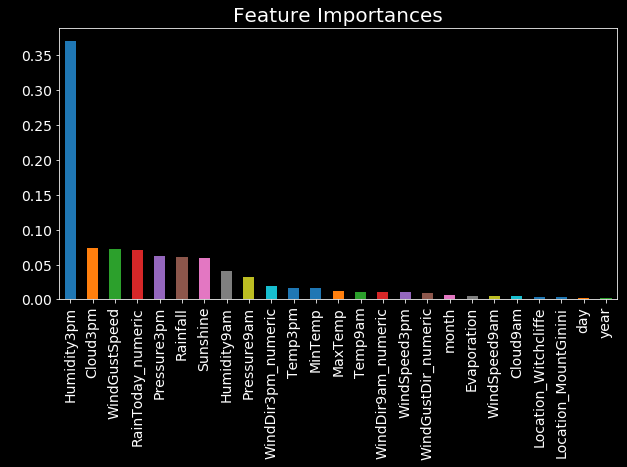

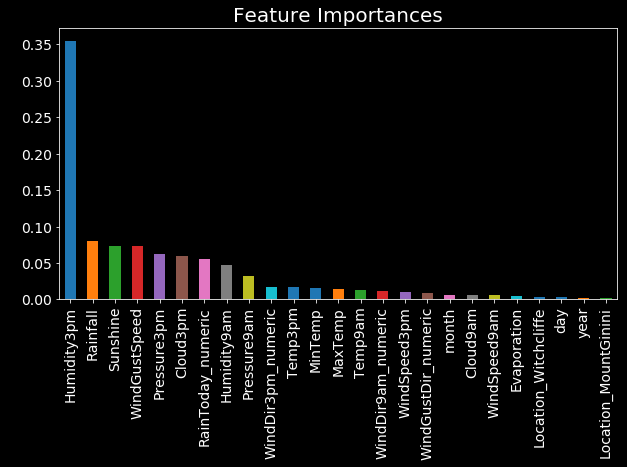

In [156]:
#initialize timer
start_time = time.time()

#initialize list for collecting model results - trainning
Accuracy_Scores_train = []
AUC_Scores_train = []
CV_mean_scores = []
CV_std = []
pred_proba_train_list = []

#initialize list for collecting model results - tests
Accuracy_Scores_test = []
AUC_Scores_test = []
pred_proba_test_list = []

#list of learning_rates and n_estimators
rates = [0.1, 0.01]
tree = [30, 300]
#rates = [0.01]
#tree = [300]

#define a loop via which model will run
for i in range(len(rates)):
    #create model using above learning rates and n_estimators and the initially obtained optimum tree parameters
    gbm_tuned_1 = GradientBoostingClassifier(learning_rate=rates[i], 
                                         n_estimators=tree[i],
                                         max_depth=15, 
                                         min_samples_split=600,
                                         min_samples_leaf=100, 
                                         subsample=0.7, 
                                         random_state=10, 
                                         max_features=19)
    #run model using initial defined function and store results in x1---x6
    x1, x2, x3, x4, x5, x6, pred_proba_train, pred_proba_test = modelfit(gbm_tuned_1, 
             x_train, 
             y_train_class, 
             x_test, 
             y_test_class,
             printConfMatrix=True,
             performCV=True, 
             printFeatureImportance=True, 
             cv_folds=5)
    #append trainning set scores to the appropraite lists
    Accuracy_Scores_train.append(round(x1, 4))
    AUC_Scores_train.append(round(x2, 4))
    CV_mean_scores.append(round(x3, 4))
    CV_std.append(round(x4, 4))
    pred_proba_train_list.append(pred_proba_train)
    
    #append test set scores to the appropraite lists
    Accuracy_Scores_test.append(round(x5, 4))
    AUC_Scores_test.append(round(x6, 4))
    pred_proba_test_list.append(pred_proba_test)
    
#unbundle results into a dataframe for ease of viewing
results = pd.DataFrame({'nTree':tree,
                        'accuracyTrain':Accuracy_Scores_train,
                        'aucTrain':AUC_Scores_train,
                        'cvmean':CV_mean_scores,
                        'cvstd':CV_std,
                        'accuracyTest':Accuracy_Scores_test,
                        'aucTest':AUC_Scores_test,
                        'learnRate':rates
                      }) 
results.set_index('learnRate')   

#calculate run time
print("--- %s seconds ---" % (time.time() - start_time))

### Further Model Performance Measurement - ROC and AUC

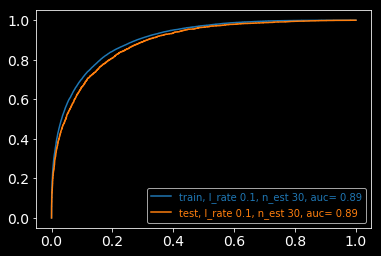

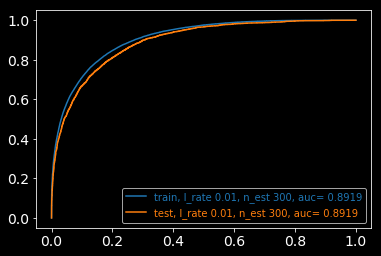

In [172]:
#plot the ROC and calculate the AUC for each pair of learning rate and n_estimators
#Here the pred_proba array for each instance of learning rate and n_estimators for the test and training tests
#have been collected into arrays pred_proba_train_list/pred_proba_test_list

for i in range(len(rates)):
    #first calculate the FPR/TPR for the training set for each instance of model
    fpr_train, tpr_train, _ = metrics.roc_curve(y_train_class, pred_proba_train_list[i])
    
    #calculate the AUC for the training set for each instance of model
    auc = round(metrics.roc_auc_score(y_train_class, pred_proba_train_list[i]),4)
    
    #do the same for the test set
    fpr, tpr, _ = metrics.roc_curve(y_test_class, pred_proba_test_list[i])
    auc = round(metrics.roc_auc_score(y_test_class, pred_proba_test_list[i]),4)
    
    #plot the ROC for the training and test set for each model instance
    with plt.rc_context({'axes.edgecolor': 'white', 
                             'xtick.color':'white', 
                             'ytick.color':'white', 
                             'figure.facecolor':'black', 
                             'xtick.labelsize':14, 
                             'ytick.labelsize':14, 
                             'axes.facecolor':'black'}):
        
        ##plt.plot(fpr_train, tpr_train,label='train, l_rate {}, n_est {}, auc= {}'.format(rates[i], tree[i], auc))
        ##plt.legend(loc=4)

        #plt.plot(fpr,tpr, label='test, l_rate {}, n_est {}, auc= {}'.format(rates[i], tree[i], auc))
        #plt.legend(loc=4)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        plot_train, = ax.plot(fpr_train, tpr_train, label='train, l_rate {}, n_est {}, auc= {}'.format(rates[i], tree[i], auc))
        plot_test, = ax.plot(fpr, tpr, label='test, l_rate {}, n_est {}, auc= {}'.format(rates[i], tree[i], auc))
        leg = ax.legend()
        text_tain, text_test = leg.get_texts()
        # this part can be turned into a loop depends on the number of text objects
        text_tain.set_color(plot_train.get_color())
        text_test.set_color(plot_test.get_color())
    
plt.show()

**The `Tree` based models have been assessed with several scoring methods and they all point to the fact that our model is quite decent in all regard. Now I will run the data through `logistic regression` as well as a way of model comparison.**

# =============================================================

### Logistic Regression
First I will adapt the data to `linear modelling` by first normalizing independent variables. This makes the training less sensitive to the scale of the data features, so we can accurately solve for coefficients.

In [50]:
#norrmalize data
min_max_scaler = preprocessing.MinMaxScaler()
x_train_norm = pd.DataFrame(min_max_scaler.fit_transform(x_train), columns=x_train.columns)
x_test_norm = pd.DataFrame(min_max_scaler.fit_transform(x_test), columns=x_test.columns)

### Use our `modelfit` function to run `logreg`
Here as a mean of cross validation I will run the `logreg` model using various values of `c`(i.e the inverse of the regularization parameter - alpha). `c` controls the regularization power of the model depending the chosen `penalty`(here I'm using `l2`). The higher `c` is, the more powerful the regularization power of the model become, i.e the more drastically it can reduce variables' coefficients.

In [51]:
#initialize list for collecting model results - trainning
Accuracy_Scores_train_lr = []
AUC_Scores_train_lr = []
CV_mean_scores_lr = []
CV_std_lr = []
pred_proba_train_list_lr = []

#initialize list for collecting model results - tests
Accuracy_Scores_test_lr = []
AUC_Scores_test_lr = []
pred_proba_test_list_lr = []

#declear the values of c to be used
c = [0.001, 0.01, 0.1, 1, 10, 100]

#create a loop to run models using the previously coded modelfit function for every value of of c
for element in c:
    
    #create model using the appropraite value of c and fit the training dataset
    logreg = LogisticRegression(penalty = 'l2', C = element,random_state = 0)

    x1, x2, x3, x4, x5, x6, pred_proba_train_lr, pred_proba_test_lr = modelfit(logreg, 
                                                                               x_train_norm, 
                                                                               y_train_class, 
                                                                               x_test_norm, 
                                                                               y_test_class,
                                                                               printConfMatrix=True,
                                                                               performCV=True, 
                                                                               printFeatureImportance=False, 
                                                                               cv_folds=5)
    
    #append trainning set scores to the appropraite lists
    Accuracy_Scores_train_lr.append(round(x1, 4))
    AUC_Scores_train_lr.append(round(x2, 4))
    CV_mean_scores_lr.append(round(x3, 4))
    CV_std_lr.append(round(x4, 4))
    pred_proba_train_list_lr.append(pred_proba_train_lr)
    
    #append test set scores to the appropraite lists
    Accuracy_Scores_test_lr.append(round(x5, 4))
    AUC_Scores_test_lr.append(round(x6, 4))
    pred_proba_test_list_lr.append(pred_proba_test_lr)
    
#unbundle results into a dataframe for ease of viewing
results_lr = pd.DataFrame({'c':c,
                        'accuracyTrain_lr':Accuracy_Scores_train_lr,
                        'aucTrain_lr':AUC_Scores_train_lr,
                        'cvmean_lr':CV_mean_scores_lr,
                        'cvstd_lr':CV_std_lr,
                        'accuracyTest_lr':Accuracy_Scores_test_lr,
                        'aucTest_lr':AUC_Scores_test_lr
                      }) 
results_lr.set_index('c')


Confusion Matrix - Train
       0     1
0  96319  2311
1  20301  7777

Confusion Matrix - Test
       0     1
0  10590   366
1   2042  1081


Model Report - Train
Accuracy : 0.8215
AUC Score (Train): 0.839539

CV Score : Mean - 0.8358683 | Std - 0.002605843 | Min - 0.8319885 | Max - 0.8396814

Model Report - Test
Accuracy : 0.829
AUC Score (Test): 0.847655

Confusion Matrix - Train
       0      1
0  94264   4366
1  15442  12636

Confusion Matrix - Test
       0     1
0  10278   678
1   1500  1623


Model Report - Train
Accuracy : 0.8437
AUC Score (Train): 0.860914

CV Score : Mean - 0.8593771 | Std - 0.00232356 | Min - 0.8571895 | Max - 0.8637227

Model Report - Test
Accuracy : 0.8453
AUC Score (Test): 0.868503

Confusion Matrix - Train
       0      1
0  93598   5032
1  14129  13949

Confusion Matrix - Test
       0     1
0  10268   688
1   1448  1675


Model Report - Train
Accuracy : 0.8488
AUC Score (Train): 0.868355

CV Score : Mean - 0.8673191 | Std - 0.002190294 | Min - 0.86589

accuracyTrain_lr  aucTrain_lr  cvmean_lr  cvstd_lr  accuracyTest_lr  \
c                                                                              
0.001              0.8215       0.8395     0.8359    0.0026           0.8290   
0.010              0.8437       0.8609     0.8594    0.0023           0.8453   
0.100              0.8488       0.8684     0.8673    0.0022           0.8483   
1.000              0.8501       0.8711     0.8705    0.0023           0.8477   
10.000             0.8502       0.8714     0.8708    0.0023           0.8479   
100.000            0.8501       0.8714     0.8708    0.0023           0.8478   

         aucTest_lr  
c                    
0.001        0.8477  
0.010        0.8685  
0.100        0.8736  
1.000        0.8747  
10.000       0.8747  
100.000      0.8747

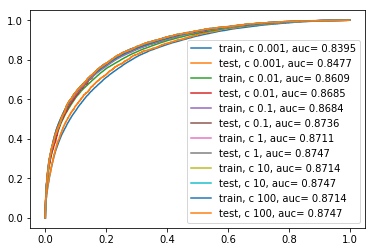

In [52]:
#plot the ROC and calculate the AUC for each value of c
#Here the pred_proba array for each instance c for the test and training tests
#have been collected into arrays pred_proba_train_list_lr/pred_proba_test_list_lr

for i in range(len(c)):
    
    #first calculate the FPR/TPR for the training set for each instance of model
    fpr_train_lr, tpr_train_lr, _ = metrics.roc_curve(y_train_class, pred_proba_train_list_lr[i])
    
    #calculate the AUC for the trraining set for each instance of model
    auc_lr = round(metrics.roc_auc_score(y_train_class, pred_proba_train_list_lr[i]),4)
    
    #plot the ROC for the training set for each model instance
    plt.plot(fpr_train_lr, tpr_train_lr,label='train, c {}, auc= {}'.format(c[i], auc_lr))
    plt.legend(loc=4)

    #do the same for the test set
    fpr_test_lr, tpr_test_lr, _ = metrics.roc_curve(y_test_class, pred_proba_test_list_lr[i])
    auc_lr = round(metrics.roc_auc_score(y_test_class, pred_proba_test_list_lr[i]),4)
    plt.plot(fpr_test_lr,tpr_test_lr, label='test, c {}, auc= {}'.format(c[i], auc_lr))
    plt.legend(loc=4)
    
plt.show()